In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)

from libs.lib import *

e:\User\PC\ads_test


In [2]:
exps_dir = "../../exps/exp1"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/Standard_Label/class_dict_weight_SMOTE/data"
os.makedirs(save_dir, exist_ok=True)

test_size=0.33
seed=42

In [3]:
feature_selection=dict(np.load(f'{save_dir}/feature_model_selection.npz',allow_pickle=True))['feature_model_selection']
feature_selection = {key: value for key, value in feature_selection.item().items()}
feature_selection

{'LR': ['AccidentArea',
  'Age',
  'AgeOfVehicle',
  'AgentType',
  'BasePolicy',
  'Deductible',
  'DriverRating',
  'Fault',
  'MaritalStatus',
  'NumberOfCars',
  'PoliceReportFiled',
  'PolicyType',
  'Sex',
  'VehicleCategory',
  'WitnessPresent'],
 'LDA': ['AccidentArea',
  'Age',
  'AgeOfVehicle',
  'AgentType',
  'BasePolicy',
  'Deductible',
  'DriverRating',
  'Fault',
  'MaritalStatus',
  'NumberOfCars',
  'PoliceReportFiled',
  'PolicyType',
  'Sex',
  'VehicleCategory',
  'WitnessPresent'],
 'DTC': ['AccidentArea',
  'Age',
  'AgeOfVehicle',
  'BasePolicy',
  'DriverRating',
  'Fault',
  'Make',
  'MaritalStatus',
  'Month',
  'MonthClaimed',
  'NumberOfSuppliments',
  'PastNumberOfClaims',
  'Sex',
  'VehicleCategory',
  'VehiclePrice'],
 'RD': ['AccidentArea',
  'Age',
  'AgeOfVehicle',
  'BasePolicy',
  'DriverRating',
  'Fault',
  'Make',
  'MaritalStatus',
  'Month',
  'MonthClaimed',
  'NumberOfSuppliments',
  'PastNumberOfClaims',
  'PolicyType',
  'VehicleCategory'

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [4]:
bg_model=joblib.load(f'{save_dir}/bg_model.joblib')
rf_model=joblib.load(f'{save_dir}/rf_model.joblib')
svm_model=joblib.load(f'{save_dir}/svm_model.joblib')

In [5]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{save_dir}/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 0.5317035512094699, 1: 8.385551948051948}

In [6]:
x_test.shape

(5089, 34)

In [7]:
x_train.shape

(19430, 34)

In [8]:
def f1_score(y_true, y_pred):
    """
    Macro F1 score metric.
    """
    # Convert predictions to binary (0 or 1)
    y_pred = K.round(y_pred)
    
    # Calculate True Positives, False Positives and False Negatives for each class
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=0)
    false_negatives = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=0)
    
    # Calculate precision and recall for each class
    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())
    
    # Calculate F1 score for each class
    f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    # Calculate macro F1 score
    macro_f1_score = K.mean(f1_scores)
    
    return macro_f1_score

In [9]:
print(x_train.shape[1])

34


#### * Xây dựng model:

In [10]:
from tensorflow.keras.optimizers import Adam
lr=0.0001
objective = Objective(name='val_f1_score', direction='max')


def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=2048, step=32),
                           activation='relu', input_dim=x_train.shape[1]))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=2048, step=32),
                           activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(units=hp.Int('units_3', min_value=32, max_value=2048, step=32),
                           activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(units=hp.Int('units_4', min_value=32, max_value=2048, step=32),
                           activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(units=hp.Int('units_5', min_value=32, max_value=2048, step=32),
                           activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy',f1_score])
    return model


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

lr=0.0001

early_stopping = EarlyStopping(monitor='val_f1_score',
    min_delta=0.00005,
    patience=50,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_f1_score',
    factor=0.5,
    patience=20,
    min_lr=0.000001,
    verbose=1,
)
# Tạo đối tượng RandomSearch tuner
tuner = RandomSearch(build_model, objective=objective, max_trials=5)

# Tìm kiếm tham số tốt nhất
tuner.search(x_train, y_train, epochs=10000, validation_data=(x_test, y_test),callbacks=[early_stopping,lr_scheduler], class_weight=class_weights_dict)

# Lấy mô hình tốt nhất
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Trial 4 Complete [00h 13m 00s]
val_f1_score: 0.2092680186033249

Best val_f1_score So Far: 0.21279659867286682
Total elapsed time: 00h 55m 24s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
1312              |2016              |units_1
1664              |96                |units_2
1408              |1952              |units_3
1856              |384               |units_4
1920              |800               |units_5



Epoch 1/10000
608/608 [==============================] - 49s 78ms/step - loss: 1.6785 - accuracy: 0.5046 - f1_score: 0.6491 - val_loss: 2.3228 - val_accuracy: 0.1377 - val_f1_score: 0.1135 - lr: 0.0010
Epoch 2/10000
608/608 [==============================] - 46s 76ms/step - loss: 0.9562 - accuracy: 0.5659 - f1_score: 0.6904 - val_loss: 2.5101 - val_accuracy: 0.1051 - val_f1_score: 0.1142 - lr: 0.0010
Epoch 3/10000
608/608 [==============================] - 47s 78ms/step - loss: 0.8262 - accuracy: 0.6127 - f1_score: 0.7140 - val_loss: 1.8956 - val_accuracy: 0.1163 - val_f1_score: 0.1151 - lr: 0.0010
Epoch 4/10000
608/608 [==============================] - 47s 78ms/step - loss: 0.7471 - accuracy: 0.6464 - f1_score: 0.7328 - val_loss: 1.2203 - val_accuracy: 0.5610 - val_f1_score: 0.1815 - lr: 0.0010
Epoch 5/10000
608/608 [==============================] - 49s 80ms/step - loss: 0.7220 - accuracy: 0.6654 - f1_score: 0.7425 - val_loss: 1.2344 - val_accuracy: 0.5575 - val_f1_score: 0.1870 - l

KeyboardInterrupt: 

In [ ]:
best_model.save_weights('weights.h5')


In [ ]:
best_trials = tuner.oracle.get_best_trials(1)[0].hyperparameters.values
best_trials

{'units_1': 1888, 'units_2': 736, 'units_3': 576, 'units_4': 64, 'units_5': 96}

#### * Xây dựng Stacked_model:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from sklearn.metrics import accuracy_score
import numpy as np
from tensorflow.keras.optimizers import Adam


# Hàm để xây dựng mô hình đầu ra
def model_output(unit1, unit2, unit3, unit4, unit5):
    lr=0.0001
    stacked_model = Sequential()
    stacked_model.add(Dense(unit1, activation='relu',input_dim=3))
    stacked_model.add(BatchNormalization())
    stacked_model.add(Dropout(0.5))

    # Thêm các lớp ẩn
    stacked_model.add(Dense(unit2, activation='relu'))
    stacked_model.add(BatchNormalization())
    stacked_model.add(Dropout(0.5))

    stacked_model.add(Dense(unit3, activation='relu'))
    stacked_model.add(BatchNormalization())
    stacked_model.add(Dropout(0.5))

    stacked_model.add(Dense(unit4, activation='relu'))
    stacked_model.add(BatchNormalization())
    stacked_model.add(Dropout(0.5))

    stacked_model.add(Dense(unit5, activation='relu'))
    stacked_model.add(BatchNormalization())
    stacked_model.add(Dropout(0.5))

    # Lớp đầu ra với activation function 'sigmoid' cho bài toán phân lớp nhị phân
    stacked_model.add(Dense(1, activation='sigmoid'))
    stacked_model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
    stacked_model.load_weights('weights.h5')
    return stacked_model




#### * Sử dụng Stacking để kết hợp dự đoán của các mô hình cơ sở để tạo ra một mô hình cuối cùng:

In [ ]:

def create_keras_model():
    # Thêm các lớp khác vào đây
    best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_score])
    best_model.load_weights('weights.h5')
    return best_model

# keras_clf = KerasClassifier(build_fn=create_keras_model, epochs=10)

# Huấn luyện các mô hình cơ sở
rf_model.fit(x_train, y_train)
bg_model.fit(x_train, y_train)
svm_model.fit(x_train, y_train)


# Dự đoán đầu ra của các mô hình cơ sở
rf_pred = rf_model.predict(x_test)
svm_pred = svm_model.predict(x_test)
bg_pred = bg_model.predict(x_test)


# keras_pred = keras_clf.predict(x_test)
stacked_input = np.column_stack((rf_pred,svm_pred,bg_pred))


#history=model.fit(x=x_train,y=y_train,
          #validation_data=(x_test,y_test),class_weight=class_weights_dict ,
          #batch_size=64,epochs=120, callbacks=[confusion_matrix_callback])

keras_clf = KerasClassifier(build_fn=model_output, unit1=best_trials['units_1'], unit2=best_trials['units_2'], unit3=best_trials['units_3'], unit4=best_trials['units_4'], unit5=best_trials['units_5'],batch_size=64,epochs=120,callbacks=[early_stopping,lr_scheduler])

# Clone lại để tránh thay đổi trực tiếp vào mô hình gốc
keras_clf = clone(keras_clf)

# Xây dựng mô hình stacking
stacked_model = StackingClassifier(
    classifiers=[rf_model, svm_model,bg_model],
    meta_classifier=keras_clf
)

# Tiếp tục với việc huấn luyện và đánh giá mô hình stacking
stacked_model.fit(stacked_input, y_test)
stacked_pred = stacked_model.predict(stacked_input)
stacked_pred

Epoch 1/120
6/6 [==============================] - 2s 14ms/step - loss: 1.0362 - accuracy: 0.4818 - lr: 1.0000e-04
Epoch 2/120
6/6 [==============================] - 0s 12ms/step - loss: 0.9415 - accuracy: 0.5545 - lr: 1.0000e-04
Epoch 3/120
6/6 [==============================] - 0s 13ms/step - loss: 0.8282 - accuracy: 0.5879 - lr: 1.0000e-04
Epoch 4/120
6/6 [==============================] - 0s 12ms/step - loss: 0.8461 - accuracy: 0.6212 - lr: 1.0000e-04
Epoch 5/120
6/6 [==============================] - 0s 12ms/step - loss: 0.7658 - accuracy: 0.6455 - lr: 1.0000e-04
Epoch 6/120
6/6 [==============================] - 0s 12ms/step - loss: 0.8037 - accuracy: 0.6455 - lr: 1.0000e-04
Epoch 7/120
6/6 [==============================] - 0s 12ms/step - loss: 0.7615 - accuracy: 0.6455 - lr: 1.0000e-04
Epoch 8/120
6/6 [==============================] - 0s 12ms/step - loss: 0.7481 - accuracy: 0.6758 - lr: 1.0000e-04
Epoch 9/120
6/6 [==============================] - 0s 12ms/step - loss: 0.7830 -

6/6 [==============================] - 0s 12ms/step - loss: 0.6954 - accuracy: 0.6788 - lr: 1.0000e-04
Epoch 19/120
6/6 [==============================] - 0s 13ms/step - loss: 0.7745 - accuracy: 0.6970 - lr: 1.0000e-04
Epoch 20/120
6/6 [==============================] - 0s 12ms/step - loss: 0.7377 - accuracy: 0.7000 - lr: 1.0000e-04
Epoch 21/120
6/6 [==============================] - 0s 12ms/step - loss: 0.8238 - accuracy: 0.6636 - lr: 1.0000e-04
Epoch 22/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6790 - accuracy: 0.7212 - lr: 1.0000e-04
Epoch 23/120
6/6 [==============================] - 0s 12ms/step - loss: 0.7043 - accuracy: 0.6970 - lr: 1.0000e-04
Epoch 24/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6744 - accuracy: 0.7242 - lr: 1.0000e-04
Epoch 25/120
6/6 [==============================] - 0s 12ms/step - loss: 0.8126 - accuracy: 0.6697 - lr: 1.0000e-04
Epoch 26/120
6/6 [==============================] - 0s 12ms/step - loss: 0.7319 - acc

6/6 [==============================] - 0s 12ms/step - loss: 0.8242 - accuracy: 0.6818 - lr: 1.0000e-04
Epoch 36/120
6/6 [==============================] - 0s 12ms/step - loss: 0.7001 - accuracy: 0.7485 - lr: 1.0000e-04
Epoch 37/120
6/6 [==============================] - 0s 12ms/step - loss: 0.7588 - accuracy: 0.7212 - lr: 1.0000e-04
Epoch 38/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6523 - accuracy: 0.7364 - lr: 1.0000e-04
Epoch 39/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6803 - accuracy: 0.7273 - lr: 1.0000e-04
Epoch 40/120
6/6 [==============================] - 0s 12ms/step - loss: 0.7225 - accuracy: 0.7273 - lr: 1.0000e-04
Epoch 41/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6791 - accuracy: 0.7273 - lr: 1.0000e-04
Epoch 42/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6733 - accuracy: 0.7000 - lr: 1.0000e-04
Epoch 43/120
6/6 [==============================] - 0s 13ms/step - loss: 0.6431 - acc

6/6 [==============================] - 0s 12ms/step - loss: 0.6575 - accuracy: 0.7455 - lr: 1.0000e-04
Epoch 54/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6716 - accuracy: 0.7333 - lr: 1.0000e-04
Epoch 55/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6494 - accuracy: 0.7273 - lr: 1.0000e-04
Epoch 56/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6464 - accuracy: 0.7697 - lr: 1.0000e-04
Epoch 57/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6540 - accuracy: 0.7455 - lr: 1.0000e-04
Epoch 58/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6643 - accuracy: 0.7667 - lr: 1.0000e-04
Epoch 59/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6583 - accuracy: 0.7455 - lr: 1.0000e-04
Epoch 60/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6476 - accuracy: 0.7121 - lr: 1.0000e-04
Epoch 61/120
6/6 [==============================] - 0s 12ms/step - loss: 0.5739 - acc

6/6 [==============================] - 0s 12ms/step - loss: 0.6880 - accuracy: 0.7515 - lr: 1.0000e-04
Epoch 71/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6471 - accuracy: 0.7303 - lr: 1.0000e-04
Epoch 72/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6287 - accuracy: 0.7333 - lr: 1.0000e-04
Epoch 73/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6149 - accuracy: 0.7424 - lr: 1.0000e-04
Epoch 74/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6114 - accuracy: 0.7333 - lr: 1.0000e-04
Epoch 75/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6205 - accuracy: 0.7727 - lr: 1.0000e-04
Epoch 76/120
6/6 [==============================] - 0s 13ms/step - loss: 0.6472 - accuracy: 0.7606 - lr: 1.0000e-04
Epoch 77/120
6/6 [==============================] - 0s 13ms/step - loss: 0.6186 - accuracy: 0.7394 - lr: 1.0000e-04
Epoch 78/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6736 - acc

6/6 [==============================] - 0s 12ms/step - loss: 0.5792 - accuracy: 0.7636 - lr: 1.0000e-04
Epoch 88/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6200 - accuracy: 0.7545 - lr: 1.0000e-04
Epoch 89/120
6/6 [==============================] - 0s 13ms/step - loss: 0.5965 - accuracy: 0.7455 - lr: 1.0000e-04
Epoch 90/120
6/6 [==============================] - 0s 13ms/step - loss: 0.6284 - accuracy: 0.7636 - lr: 1.0000e-04
Epoch 91/120
6/6 [==============================] - 0s 13ms/step - loss: 0.5672 - accuracy: 0.7879 - lr: 1.0000e-04
Epoch 92/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6779 - accuracy: 0.7212 - lr: 1.0000e-04
Epoch 93/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6353 - accuracy: 0.7667 - lr: 1.0000e-04
Epoch 94/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6790 - accuracy: 0.7909 - lr: 1.0000e-04
Epoch 95/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6325 - acc

6/6 [==============================] - 0s 12ms/step - loss: 0.6244 - accuracy: 0.7242 - lr: 1.0000e-04
Epoch 106/120
6/6 [==============================] - 0s 12ms/step - loss: 0.5298 - accuracy: 0.7727 - lr: 1.0000e-04
Epoch 107/120
6/6 [==============================] - 0s 12ms/step - loss: 0.5480 - accuracy: 0.7697 - lr: 1.0000e-04
Epoch 108/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6262 - accuracy: 0.7485 - lr: 1.0000e-04
Epoch 109/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6016 - accuracy: 0.7636 - lr: 1.0000e-04
Epoch 110/120
6/6 [==============================] - 0s 12ms/step - loss: 0.5732 - accuracy: 0.7818 - lr: 1.0000e-04
Epoch 111/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6220 - accuracy: 0.7545 - lr: 1.0000e-04
Epoch 112/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6474 - accuracy: 0.7424 - lr: 1.0000e-04
Epoch 113/120
6/6 [==============================] - 0s 12ms/step - loss: 0.62

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
    

In [ ]:
print(keras_clf)

In [ ]:
stacked_model.fit(stacked_input, y_test)
# Dự đoán và đánh giá mô hình stacked
stacked_pred = stacked_model.predict(stacked_input)
stacked_pred_binary = (stacked_pred > 0.5).astype(int)
accuracy_stacked = accuracy_score(y_test, stacked_pred_binary)
print(f'Accuracy of Stacked Model: {accuracy_stacked}')

Epoch 1/120
6/6 [==============================] - 2s 12ms/step - loss: 1.1664 - accuracy: 0.4606 - lr: 1.0000e-04
Epoch 2/120
6/6 [==============================] - 0s 12ms/step - loss: 1.0522 - accuracy: 0.5485 - lr: 1.0000e-04
Epoch 3/120
6/6 [==============================] - 0s 12ms/step - loss: 0.8850 - accuracy: 0.5818 - lr: 1.0000e-04
Epoch 4/120
6/6 [==============================] - 0s 12ms/step - loss: 0.9300 - accuracy: 0.5394 - lr: 1.0000e-04
Epoch 5/120
6/6 [==============================] - 0s 12ms/step - loss: 0.9224 - accuracy: 0.5727 - lr: 1.0000e-04
Epoch 6/120
6/6 [==============================] - 0s 12ms/step - loss: 0.8512 - accuracy: 0.6000 - lr: 1.0000e-04
Epoch 7/120
6/6 [==============================] - 0s 12ms/step - loss: 0.8251 - accuracy: 0.6212 - lr: 1.0000e-04
Epoch 8/120
6/6 [==============================] - 0s 13ms/step - loss: 0.7814 - accuracy: 0.6303 - lr: 1.0000e-04
Epoch 9/120
6/6 [==============================] - 0s 12ms/step - loss: 0.7969 -

6/6 [==============================] - 0s 12ms/step - loss: 0.7393 - accuracy: 0.6939 - lr: 1.0000e-04
Epoch 19/120
6/6 [==============================] - 0s 12ms/step - loss: 0.7452 - accuracy: 0.7152 - lr: 1.0000e-04
Epoch 20/120
6/6 [==============================] - 0s 12ms/step - loss: 0.7028 - accuracy: 0.7152 - lr: 1.0000e-04
Epoch 21/120
6/6 [==============================] - 0s 12ms/step - loss: 0.7608 - accuracy: 0.6758 - lr: 1.0000e-04
Epoch 22/120
6/6 [==============================] - 0s 12ms/step - loss: 0.7799 - accuracy: 0.6970 - lr: 1.0000e-04
Epoch 23/120
6/6 [==============================] - 0s 12ms/step - loss: 0.7184 - accuracy: 0.7030 - lr: 1.0000e-04
Epoch 24/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6989 - accuracy: 0.7030 - lr: 1.0000e-04
Epoch 25/120
6/6 [==============================] - 0s 12ms/step - loss: 0.7795 - accuracy: 0.7061 - lr: 1.0000e-04
Epoch 26/120
6/6 [==============================] - 0s 12ms/step - loss: 0.7289 - acc

6/6 [==============================] - 0s 12ms/step - loss: 0.7769 - accuracy: 0.7182 - lr: 1.0000e-04
Epoch 36/120
6/6 [==============================] - 0s 12ms/step - loss: 0.7483 - accuracy: 0.7061 - lr: 1.0000e-04
Epoch 37/120
6/6 [==============================] - 0s 12ms/step - loss: 0.7397 - accuracy: 0.7242 - lr: 1.0000e-04
Epoch 38/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6981 - accuracy: 0.7212 - lr: 1.0000e-04
Epoch 39/120
6/6 [==============================] - 0s 11ms/step - loss: 0.6598 - accuracy: 0.7121 - lr: 1.0000e-04
Epoch 40/120
6/6 [==============================] - 0s 12ms/step - loss: 0.7120 - accuracy: 0.7061 - lr: 1.0000e-04
Epoch 41/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6224 - accuracy: 0.7212 - lr: 1.0000e-04
Epoch 42/120
6/6 [==============================] - 0s 12ms/step - loss: 0.7112 - accuracy: 0.7242 - lr: 1.0000e-04
Epoch 43/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6133 - acc

6/6 [==============================] - 0s 12ms/step - loss: 0.6709 - accuracy: 0.7273 - lr: 1.0000e-04
Epoch 54/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6344 - accuracy: 0.7303 - lr: 1.0000e-04
Epoch 55/120
6/6 [==============================] - 0s 12ms/step - loss: 0.5996 - accuracy: 0.7909 - lr: 1.0000e-04
Epoch 56/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6705 - accuracy: 0.7273 - lr: 1.0000e-04
Epoch 57/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6622 - accuracy: 0.7364 - lr: 1.0000e-04
Epoch 58/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6469 - accuracy: 0.7333 - lr: 1.0000e-04
Epoch 59/120
6/6 [==============================] - 0s 12ms/step - loss: 0.7254 - accuracy: 0.7182 - lr: 1.0000e-04
Epoch 60/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6770 - accuracy: 0.7545 - lr: 1.0000e-04
Epoch 61/120
6/6 [==============================] - 0s 11ms/step - loss: 0.6852 - acc

6/6 [==============================] - 0s 12ms/step - loss: 0.6259 - accuracy: 0.7576 - lr: 1.0000e-04
Epoch 71/120
6/6 [==============================] - 0s 12ms/step - loss: 0.7035 - accuracy: 0.7212 - lr: 1.0000e-04
Epoch 72/120
6/6 [==============================] - 0s 11ms/step - loss: 0.6771 - accuracy: 0.7303 - lr: 1.0000e-04
Epoch 73/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6711 - accuracy: 0.7273 - lr: 1.0000e-04
Epoch 74/120
6/6 [==============================] - 0s 11ms/step - loss: 0.6591 - accuracy: 0.7333 - lr: 1.0000e-04
Epoch 75/120
6/6 [==============================] - 0s 12ms/step - loss: 0.7607 - accuracy: 0.7121 - lr: 1.0000e-04
Epoch 76/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6334 - accuracy: 0.7606 - lr: 1.0000e-04
Epoch 77/120
6/6 [==============================] - 0s 11ms/step - loss: 0.5862 - accuracy: 0.7485 - lr: 1.0000e-04
Epoch 78/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6388 - acc

6/6 [==============================] - 0s 12ms/step - loss: 0.6419 - accuracy: 0.7485 - lr: 1.0000e-04
Epoch 88/120
6/6 [==============================] - 0s 12ms/step - loss: 0.5983 - accuracy: 0.7576 - lr: 1.0000e-04
Epoch 89/120
6/6 [==============================] - 0s 11ms/step - loss: 0.6576 - accuracy: 0.7576 - lr: 1.0000e-04
Epoch 90/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6173 - accuracy: 0.7485 - lr: 1.0000e-04
Epoch 91/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6111 - accuracy: 0.7515 - lr: 1.0000e-04
Epoch 92/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6157 - accuracy: 0.7485 - lr: 1.0000e-04
Epoch 93/120
6/6 [==============================] - 0s 11ms/step - loss: 0.5974 - accuracy: 0.7394 - lr: 1.0000e-04
Epoch 94/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6100 - accuracy: 0.7788 - lr: 1.0000e-04
Epoch 95/120
6/6 [==============================] - 0s 12ms/step - loss: 0.5813 - acc

6/6 [==============================] - 0s 12ms/step - loss: 0.6249 - accuracy: 0.7333 - lr: 1.0000e-04
Epoch 106/120
6/6 [==============================] - 0s 12ms/step - loss: 0.5687 - accuracy: 0.7697 - lr: 1.0000e-04
Epoch 107/120
6/6 [==============================] - 0s 14ms/step - loss: 0.6026 - accuracy: 0.7697 - lr: 1.0000e-04
Epoch 108/120
6/6 [==============================] - 0s 12ms/step - loss: 0.5801 - accuracy: 0.7606 - lr: 1.0000e-04
Epoch 109/120
6/6 [==============================] - 0s 12ms/step - loss: 0.5894 - accuracy: 0.7273 - lr: 1.0000e-04
Epoch 110/120
6/6 [==============================] - 0s 12ms/step - loss: 0.5288 - accuracy: 0.7758 - lr: 1.0000e-04
Epoch 111/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6165 - accuracy: 0.7394 - lr: 1.0000e-04
Epoch 112/120
6/6 [==============================] - 0s 12ms/step - loss: 0.6230 - accuracy: 0.7818 - lr: 1.0000e-04
Epoch 113/120
6/6 [==============================] - 0s 12ms/step - loss: 0.61

#### * Kết quả đánh giá mô hình:

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix




# Đánh giá độ chính xác
accuracy = accuracy_score(y_test, stacked_pred)
print("Accuracy:", accuracy)

# Hiển thị báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, stacked_pred,labels=[1,0]))

# # Hiển thị ma trận nhầm lẫn
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred,labels=[1,0]))

Accuracy: 0.8333333333333334
Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.85      0.73        88
           0       0.94      0.83      0.88       242

    accuracy                           0.83       330
   macro avg       0.79      0.84      0.81       330
weighted avg       0.86      0.83      0.84       330



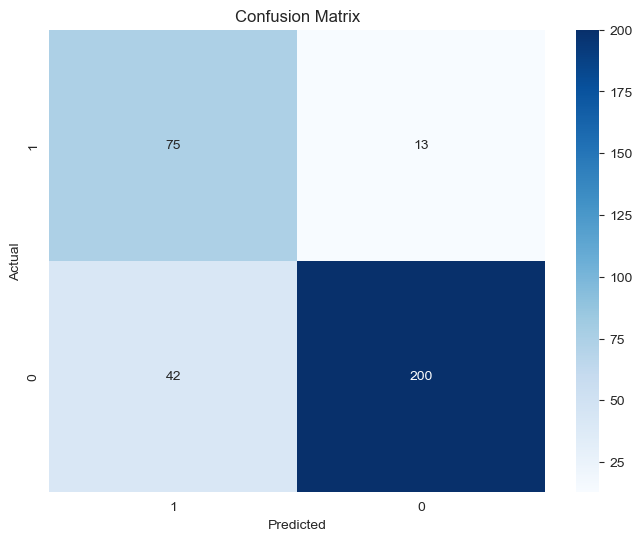

In [ ]:
# Dự đoán


# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, stacked_pred,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
def check_result(prediction):
    prediction = (prediction > 0.5).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [ ]:
solandung=0
hopdonggianlan=0
for indx in range(len(x_test)):
    y_predict = stacked_model.predict(stacked_input)
    #print(y_predict[0][0])
    Y_check = check_result(y_test.iloc[indx])
    print('True:', Y_check)
    print('Predicted:', check_result(y_predict[indx]))
    print("----------------------------")
    if Y_check==check_result(y_predict[indx]):
        solandung+=1
        if Y_check=='Y':
            hopdonggianlan+=1
    

11/11 [==============================] - 0s 2ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 2ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: Y
Predicted: Y
----------------------------
11/11 [==============================] - 0s 2ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N

11/11 [==============================] - 0s 2ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: Y
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 2ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: Y
----------------------------
11/11 [==============================] - 0s 2ms/step
True: N
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N

11/11 [==============================] - 0s 3ms/step
True: N
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: Y
----------------------------
11/11 [==============================] - 0s 2ms/step
True: Y
Predicted: Y
----------------------------
11/11 [==============================] - 0s 2ms/step
True: Y
Predicted: Y
----------------------------
11/11 [==============================] - 0s 2ms/step
True: Y
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 2ms/step
True: N
Predicted: Y
----------------------------
11/11 [==============================] - 0s 2ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 2ms/step
True: Y
Predicted: Y

11/11 [==============================] - 0s 3ms/step
True: Y
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 2ms/step
True: N
Predicted: Y
----------------------------
11/11 [==============================] - 0s 2ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: Y
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: Y
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: Y
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N

11/11 [==============================] - 0s 2ms/step
True: Y
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: Y
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: Y
----------------------------
11/11 [==============================] - 0s 2ms/step
True: Y
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 2ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 2ms/step
True: Y
Predicted: Y
----------------------------
11/11 [==============================] - 0s 2ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 2ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 2ms/step
True: N
Predicted: N

In [ ]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['fraud_reported']==1]))*100}% so với thực tế")


Số lần dự đoán đúng: 275 chiếm khoảng 83.33333333333334% tổng lần dự đoán
Số hợp đồng gian lận trong lần kiểm tra: 75 chiếm khoảng 85.22727272727273% so với thực tế
